# [2-BENCHMARK] - Phase de sélection des modèles

## Import des modules
> cf. [pyproject.toml](pyproject.toml) pour connaître les librairies à installer

In [1]:
import os
import io
import json
import boto3
import joblib
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Récupération des données dans le stockage objet AWS S3

In [2]:
# Configutations S3 access and data
load_dotenv()
aws_access_key_id = os.getenv('aws_access_key_id')
aws_secret_access_key = os.getenv('aws_secret_access_key')

In [3]:
# Specific bucket data
bucket_name = "hotel-resa-prediction"
prefix = "datasets/"
filename = "processed_hotel_bookings.csv"

In [4]:
# S3 connection
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
)

In [5]:
# get datas 
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        data = pd.read_csv(io.StringIO(contents), low_memory=False)

In [6]:
data.head().T

,0,1,2,3,4
lead_time,342,737,7,13,14
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
children,0.0,0.0,0.0,0.0,0.0
babies,0,0,0,0,0
previous_cancellations,0,0,0,0,0
previous_bookings_not_canceled,0,0,0,0,0
booking_changes,3,4,0,0,0
adr,0.0,0.0,75.0,75.0,98.0


## Découpe des données en train et test

**Info :** Nous allons séparer les données en variable à expliquer (target) y et en variable expliquer (features).

In [7]:
X = data.drop("is_canceled",  axis=1)
y = data["is_canceled"]
print("Features : ", X.shape)
print("Target : ", y.shape) # s'assurer de n'avoir qu'une colonne ici

Features :  (119210, 30)
Target :  (119210,)


**Info** : Pour l'apprentissage, nous avons besoin de séparer en deux partie, un jeu d'entraînement et un jeu de test. Nous faisons le choix de découper en 70/30 soit 70 en jeu d'entraînement et 30 en jeu de test. Ici, nous faisons le choix de ne par garder de dépendance temporelle c'est la raison pour laquelle on a mélanger le jeux de données avec la méthode shuffle.

> **IMPORTANT** --> stratify a été crutial pour bien balancer car à la première itération on avait des résultats qui faisait moins bien que le hasard.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    shuffle=True, 
    stratify=y # IMPORTANT pour bien balancer les prédictions première itération --> courbe ROC mauvais 
)
print("Features train : ", X_train.shape)
print("Target train : ", y_train.shape)
print("Features test : ", X_test.shape)
print("Target test : ", y_test.shape)

Features train :  (83447, 30)
Target train :  (83447,)
Features test :  (35763, 30)
Target test :  (35763,)


**Info** : Pour bien valider la distribution de la variable à expliquer en fonction des features, je vérifie quand même les éléments X et y pour être sur.

In [9]:
# Pour voir la distribution dans y_train --> Valider le stratify
print("Distribution y_train:")
print(y_train.value_counts())
print("\nPourcentages y_train:")
print(y_train.value_counts(normalize=True) * 100)

# Pour voir la distribution dans y_test --> Valider  le stratify
print("\nDistribution y_test:")
print(y_test.value_counts())
print("\nPourcentages y_test:")
print(y_test.value_counts(normalize=True) * 100)

# Pour voir la distribution dans le dataset complet --> Valider  le stratify
print("\nDistribution dataset complet:")
print(y.value_counts())
print("\nPourcentages dataset complet:")
print(y.value_counts(normalize=True) * 100)

Distribution y_train:
is_canceled
0    52508
1    30939
Name: count, dtype: int64

Pourcentages y_train:
is_canceled
0    62.923772
1    37.076228
Name: proportion, dtype: float64

Distribution y_test:
is_canceled
0    22503
1    13260
Name: count, dtype: int64

Pourcentages y_test:
is_canceled
0    62.922574
1    37.077426
Name: proportion, dtype: float64

Distribution dataset complet:
is_canceled
0    75011
1    44199
Name: count, dtype: int64

Pourcentages dataset complet:
is_canceled
0    62.923412
1    37.076588
Name: proportion, dtype: float64


## Préparation des pipelines de classifications

### Etape préprocesseur
> on utilise le OneHotEncoder pour les variables catégoriels et le StandardScaler (centré-réduit) pour les variables numériques

In [10]:
categorical_data = selector(dtype_include=object)
numerical_data = selector(dtype_exclude=object)

In [11]:
n_categorical = categorical_data(X)
n_numerical = numerical_data(X)

In [12]:
print(f"Categorial : {len(n_categorical)}")
print(f"Numerical : {len(n_numerical)}")

Categorial : 15
Numerical : 15


In [13]:
numeric_preprocessor = StandardScaler()
categoric_preprocessor = OneHotEncoder(
    handle_unknown='ignore'
)

In [14]:
preprocessor = ColumnTransformer(
    [
        ("numerical", numeric_preprocessor, n_numerical),
        ("Categorical", categoric_preprocessor, n_categorical)
    ],
    remainder = "passthrough",
)
preprocessor

,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### Définition des modèles à benchmarker
Un premier modèle linéaire ensuite un modèle d'arbre et un modèle de random forest. l'idée est d'ajouter ce modèle au pipeline sans configuration pour faire une première sélection pour afiner plus tards.

In [15]:
model_linear = LogisticRegression() 

In [16]:
model_tree = DecisionTreeClassifier() 

In [17]:
model_ensemble = RandomForestClassifier() 

### Définition des pipelines complets

In [18]:
linear_pipeline = make_pipeline(
    preprocessor,
    model_linear
)
linear_pipeline

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
tree_pipeline = make_pipeline(
    preprocessor,
    model_tree
)
tree_pipeline

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
ensemble_pipeline = make_pipeline(
    preprocessor,
    model_ensemble
)
ensemble_pipeline

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Benchmark par validation croisée

### Lancer les validations croisées

In [21]:
cv_linear = cross_validate(
    linear_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_linear = pd.DataFrame(cv_linear)

/Users/mandresyandri/Library/Caches/pypoetry/virtualenvs/model-build-Uli2Bxu9-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mandresyandri/Library/Caches/pypoetry/virtualenvs/model-build-Uli2Bxu9-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (m

In [22]:
cv_tree = cross_validate(
    tree_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_tree = pd.DataFrame(cv_tree)

In [23]:
cv_ensemble = cross_validate(
    ensemble_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_ensemble = pd.DataFrame(cv_ensemble)

### Récupération des métriques et visualisation des résultats

In [24]:
linear_scores = -cv_linear["test_score"] * 100
tree_scores = -cv_tree["test_score"] * 100
ensemble_scores = -cv_ensemble["test_score"] * 100

In [25]:
indices = np.arange(len(cv_linear)) 

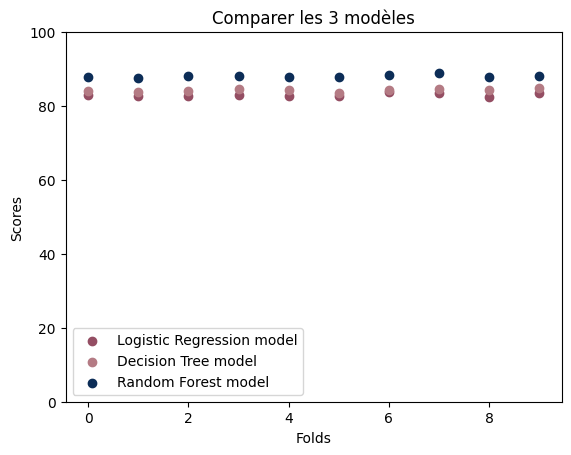

In [26]:
plt.scatter(
    indices,
    -linear_scores,
    color="#944E63",
    label="Logistic Regression model"
)

plt.scatter(
    indices,
    -tree_scores,
    color="#B47B84",
    label="Decision Tree model"
)

plt.scatter(
    indices,
    -ensemble_scores,
    color="#0C2D57",
    label="Random Forest model"
)

plt.ylim((0,100))
plt.legend()
plt.xlabel("Folds")
plt.ylabel("Scores")
_ = plt.title("Comparer les 3 modèles")

In [27]:
model_scores = {
    "Logistic Regression": -linear_scores.mean(),
    "Decision Tree Model": -tree_scores.mean(),
    "Random Forest": -ensemble_scores.mean()
}

In [28]:
highest_score = max(model_scores.values())

In [29]:
best_models = [model for model, score in model_scores.items() if score == highest_score] 

In [30]:
if len(best_models) == 1:
    print(f"Le modèle avec le plus haut accuracy score ({highest_score:.2f}%) est: {best_models[0]}")
else:
    print(f"Le modèle avec le plus haut accuracy score ({highest_score:.2f}%) sont:")
    for model in best_models:
        print(f"\t- {model}")

Le modèle avec le plus haut accuracy score (88.05%) est: Random Forest


**Conclusions** : à première vue, on peut dire que le modèle le plus performant sur les 10 folds est le Random Forest. avec un accuracy à 88%. 

### Validation finale
> L'accuracy n'est pas forcément la seule manière de vérifier la performance du modèle en classification binaire, nous allons confirmer ceci avec le score ROC-AUC pour bien valider le modèle.

**Info** : Lancer l'entrainement pour avoir le score

In [31]:
linear_pipeline.fit(X_train, y_train)
tree_pipeline.fit(X_train, y_train)
ensemble_pipeline.fit(X_train, y_train)

/Users/mandresyandri/Library/Caches/pypoetry/virtualenvs/model-build-Uli2Bxu9-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
print("Resultat pour la régression logistique : ")
y_pred = linear_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, linear_pipeline.predict_proba(X_test)[:,1]))

Resultat pour la régression logistique : 
              precision    recall  f1-score   support

           0      0.842     0.909     0.874     22503
           1      0.821     0.710     0.762     13260

    accuracy                          0.835     35763
   macro avg      0.831     0.810     0.818     35763
weighted avg      0.834     0.835     0.832     35763

ROC-AUC: 0.9112459565471713


In [33]:
print("Resultat pour l'arbre de décision : ")
y_pred = tree_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, tree_pipeline.predict_proba(X_test)[:,1]))

Resultat pour l'arbre de décision : 
              precision    recall  f1-score   support

           0      0.880     0.874     0.877     22503
           1      0.789     0.797     0.793     13260

    accuracy                          0.846     35763
   macro avg      0.834     0.836     0.835     35763
weighted avg      0.846     0.846     0.846     35763

ROC-AUC: 0.8377303790364402


In [34]:
print("Resultat pour le random forest : ")
y_pred = ensemble_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, ensemble_pipeline.predict_proba(X_test)[:,1]))

Resultat pour le random forest : 
              precision    recall  f1-score   support

           0      0.880     0.943     0.911     22503
           1      0.890     0.783     0.833     13260

    accuracy                          0.884     35763
   macro avg      0.885     0.863     0.872     35763
weighted avg      0.884     0.884     0.882     35763

ROC-AUC: 0.9486929361320618


les résultats montrent bien que le meilleur modèle ici est bien le random forest. Il est donc temps d'affiner les hyperparamètres de ce modèle pour essayer d'optimiser et de le rendre explicable.

## Exporter le modèle sur le cloud

In [35]:
prefix = "models/"
filename_model = "hotel_bookings_churn_model.pkl"

In [36]:
try:
    os.makedirs(prefix, exist_ok=True)
    joblib.dump(ensemble_pipeline, prefix + filename_model)
    print(f"Modèle optimal enregistré avec succès ({best_models[0]}) sous le nom {filename_model}.")
except Exception as e:
    print(f"Erreur lors du téléversement du modèle : {e}")

Modèle optimal enregistré avec succès (Random Forest) sous le nom hotel_bookings_churn_model.pkl.


In [37]:
s3.upload_file(prefix + filename_model, bucket_name, prefix + filename_model) 

In [38]:
os.chdir(prefix)
os.remove(filename_model)
print("models : ")
print("- - - " * 3)
if len(os.listdir()) > 1:
        for file in os.listdir():
            print(file)
else: 
    print("Vous retrouverez le modèle sur AWS S3 !")
os.chdir("../")

models : 
- - - - - - - - - 
Vous retrouverez le modèle sur AWS S3 !


-- END --